In [1]:
import pickle
import os
from traffic_equilibrium.solver import Result as FWResult
from traffic_equilibrium.graph import DiGraph
from shapely.geometry import LineString, MultiLineString
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape, LineString
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx
import seaborn as sns
import itertools as it
import osmnx as ox
import geopy.distance as geo_distance
import hashlib
import uuid

sns.set_context("paper")
matplotlib.style.use('./figures.mplstyle')
matplotlib.rcParams["savefig.dpi"] = 300
plt.rcParams["font.family"] = "Latin Modern Sans"
PROJECT_ROOT = '..'

In [2]:
FEET_PER_MILE = 5280.0

In [3]:
def simplify_columns(df):
    cols = pd.DataFrame(df.columns.to_list(), columns=["id", "name"]).set_index("id")
    df.columns = df.columns.droplevel(1)
    return df, cols

In [4]:
families = pd.read_csv(
    "data/ACSST5Y2020.S1702_data_with_overlays_2022-06-10T104922.csv",
    header=[0, 1],
).set_index([("GEO_ID", "id"), ("NAME", "Geographic Area Name")]).rename_axis(["geoid", "name"])

In [5]:
individuals = pd.read_csv(
    "data/ACSST5Y2020.S1701_data_with_overlays_2022-06-10T113703.csv",
    header=[0, 1],
).set_index([("GEO_ID", "id"), ("NAME", "Geographic Area Name")]).rename_axis(["geoid", "name"])

In [6]:
families, families_cols = simplify_columns(families)

In [7]:
individuals, individuals_cols = simplify_columns(individuals)

In [8]:
class Name:
    individuals = "S1701"
    families = "S1702"
    
class Race:
    white = "White alone"
    black = "Black or African American alone"
    native = "American Indian and Alaska Native alone"
    asian = "Asian alone"
    native_pi = "Native Hawaiian and Other Pacific Islander alone"
    other = "Some other race alone"
    mixed = "Two or more races"
    hispanic = "Hispanic or Latino origin (of any race)"
    non_hispanic_white = "White alone, not Hispanic or Latino"

class DataKind:
    total = "Total"
    poverty = "Below poverty level"
    poverty_percent = "Percent below poverty level"  # percent of families of that racial group below poverty

In [9]:
def get_col_range(name, category, start, end):
    for i in range(start, end+1):
         yield f"{name}_C{category:02d}_{i:03d}E"

In [10]:
def to_multilevel(name, indices):
    parts = name.split("!!")
    return tuple(parts[i] for i in indices)

In [11]:
individuals_race_poverty_cols = (
    list(get_col_range(Name.individuals, 1, 13, 21))
    + list(get_col_range(Name.individuals, 2, 13, 21))
)

In [12]:
individuals_race_poverty = individuals[individuals_race_poverty_cols]
individuals_race_poverty.columns = pd.MultiIndex.from_tuples(
    individuals_cols.loc[individuals_race_poverty_cols].name.apply(to_multilevel, indices=[1, 4]).values,
    names=["kind", "race"]
)
individuals_race_poverty.reset_index(level="name", inplace=True)
tract_names = individuals_race_poverty.pop("name")
individuals_race_poverty = individuals_race_poverty.astype(np.float64)
_df = (individuals_race_poverty[DataKind.poverty] / individuals_race_poverty[DataKind.total]).fillna(0.0)
_df.columns = pd.MultiIndex.from_product([[DataKind.poverty_percent], _df.columns], names=individuals_race_poverty.columns.names)
individuals_race_poverty = pd.concat([individuals_race_poverty, _df], axis=1)
individuals_race_poverty.head()

kind                       Total                                  \
race                 White alone Black or African American alone   
geoid                                                              
1400000US42003010301         0.0                             0.0   
1400000US42003010302       417.0                           257.0   
1400000US42003020100      2520.0                           313.0   
1400000US42003020300      1151.0                            24.0   
1400000US42003030500       742.0                          1596.0   

kind                                                                      \
race                 American Indian and Alaska Native alone Asian alone   
geoid                                                                      
1400000US42003010301                                     0.0         0.0   
1400000US42003010302                                     6.0        69.0   
1400000US42003020100                                     7.0       514.0   
1400000US42003020300                                     0.0       148.0   
1400000US42003030500                                     3.0       226.0   

kind                                                                   \
race                 Native Hawaiian and Other Pacific Islander alone   
geoid                                                                   
1400000US42003010301                                              0.0   
1400000US42003010302                                              0.0   
1400000US42003020100                                              0.0   
1400000US42003020300                                              0.0   
1400000US42003030500                                              0.0   

kind                                                          \
race                 Some other race alone Two or more races   
geoid                                                          
1400000US42003010301                   0.0               0.0   
1400000US42003010302                   7.0              41.0   
1400000US42003020100                   0.0             102.0   
1400000US42003020300                   1.0              44.0   
1400000US42003030500                   0.0              88.0   

kind                                                          \
race                 Hispanic or Latino origin (of any race)   
geoid                                                          
1400000US42003010301                                     0.0   
1400000US42003010302                                    34.0   
1400000US42003020100                                   136.0   
1400000US42003020300                                    56.0   
1400000US42003030500                                   116.0   

kind                                                     Below poverty level  \
race                 White alone, not Hispanic or Latino         White alone   
geoid                                                                          
1400000US42003010301                                 0.0                 0.0   
1400000US42003010302                               400.0               174.0   
1400000US42003020100                              2425.0               225.0   
1400000US42003020300                              1108.0               114.0   
1400000US42003030500                               656.0               151.0   

kind                  ...                                      \
race                  ... White alone, not Hispanic or Latino   
geoid                 ...                                       
1400000US42003010301  ...                                 0.0   
1400000US42003010302  ...                               165.0   
1400000US42003020100  ...                               215.0   
1400000US42003020300  ...                               112.0   
1400000US42003030500  ...                               133.0   

kind                 Percent below poverty level  \
race                 

In [13]:
ind_race_poverty_l = individuals_race_poverty[DataKind.total].melt(
    value_name="population",
    ignore_index=False,
).set_index("race", append=True
).join(
    individuals_race_poverty[DataKind.poverty].melt(value_name="poverty", ignore_index=False).set_index("race", append=True))
ind_race_poverty_l["non_poverty"] = ind_race_poverty_l.population - ind_race_poverty_l.poverty
ind_race_poverty_l = (
    ind_race_poverty_l.drop(columns="population")
                      .rename(columns={"poverty": True, "non_poverty": False})
                      .melt(ignore_index=False, var_name="poverty", value_name="population")
                      .set_index("poverty", append=True)
)
ind_race_poverty_l

,,,population
geoid,race,poverty,
1400000US42003010301,White alone,True,0.0
1400000US42003010302,White alone,True,174.0
1400000US42003020100,White alone,True,225.0
1400000US42003020300,White alone,True,114.0
1400000US42003030500,White alone,True,151.0
...,...,...,...
1400000US42003981000,"White alone, not Hispanic or Latino",False,0.0
1400000US42003981100,"White alone, not Hispanic or Latino",False,0.0
1400000US42003981200,"White alone, not Hispanic or Latino",False,0.0


In [14]:
# ind_race_poverty_l = individuals_race_poverty[DataKind.total].reset_index().melt(id_vars=["geoid"], value_name="population").set_index(["geoid", "race"]).join(
#     individuals_race_poverty[DataKind.poverty].reset_index().melt(id_vars=["geoid"], value_name="poverty").set_index(["geoid", "race"])
# ).join(
#         individuals_race_poverty[DataKind.poverty_percent].reset_index().melt(id_vars=["geoid"], value_name="poverty_percent").set_index(["geoid", "race"])
# )
# #ind_race_poverty_l["population_percent"] = ind_race_poverty_l.groupby("geoid").population.transform(lambda pop: pop / pop.sum()).fillna(0.0)
# #ind_race_poverty_l["race_poverty_percent"] = ind_race_poverty_l.poverty_percent * ind_race_poverty_l.population_percent
# #ind_race_poverty_l["race_percent"] = ind_race_poverty_l.groupby("race").population.transform(lambda pop: pop / pop.sum()).fillna(0.0)
# ind_race_poverty_l

In [15]:
families_race_poverty_cols = (
    list(get_col_range(Name.families, 1, 6, 14))
    + list(get_col_range(Name.families, 2, 6, 14))
)

In [16]:
families_race_poverty = families[families_race_poverty_cols]
families_race_poverty.columns = pd.MultiIndex.from_tuples(
    families_cols.loc[families_race_poverty_cols].name.apply(to_multilevel, indices=[1, 6]).values,
    names=["kind", "race"]
)
families_race_poverty = families_race_poverty.where(families_race_poverty != "-", 0).astype(np.float64)
_df = families_race_poverty[DataKind.total] * (families_race_poverty[DataKind.poverty_percent] / 100.0)
_df.columns = pd.MultiIndex.from_product([[DataKind.poverty], _df.columns], names=families_race_poverty.columns.names)
families_race_poverty = pd.concat([families_race_poverty, _df], axis=1)
families_race_poverty.head()

kind                                                                          Total  \
race                                                                    White alone   
geoid                name                                                             
1400000US42003010301 Census Tract 103.01, Allegheny County, Pennsylv...         0.0   
1400000US42003010302 Census Tract 103.02, Allegheny County, Pennsylv...        42.0   
1400000US42003020100 Census Tract 201, Allegheny County, Pennsylvania         463.0   
1400000US42003020300 Census Tract 203, Allegheny County, Pennsylvania         133.0   
1400000US42003030500 Census Tract 305, Allegheny County, Pennsylvania         164.0   

kind                                                                                                     \
race                                                                    Black or African American alone   
geoid                name                                                                                 
1400000US42003010301 Census Tract 103.01, Allegheny County, Pennsylv...                             0.0   
1400000US42003010302 Census Tract 103.02, Allegheny County, Pennsylv...                            58.0   
1400000US42003020100 Census Tract 201, Allegheny County, Pennsylvania                              22.0   
1400000US42003020300 Census Tract 203, Allegheny County, Pennsylvania                               5.0   
1400000US42003030500 Census Tract 305, Allegheny County, Pennsylvania                             409.0   

kind                                                                                                             \
race                                                                    American Indian and Alaska Native alone   
geoid                name                                                                                         
1400000US42003010301 Census Tract 103.01, Allegheny County, Pennsylv...                                     0.0   
1400000US42003010302 Census Tract 103.02, Allegheny County, Pennsylv...                                     0.0   
1400000US42003020100 Census Tract 201, Allegheny County, Pennsylvania                                       7.0   
1400000US42003020300 Census Tract 203, Allegheny County, Pennsylvania                                       0.0   
1400000US42003030500 Census Tract 305, Allegheny County, Pennsylvania                                       0.0   

kind                                                                                 \
race                                                                    Asian alone   
geoid                name                                                             
1400000US42003010301 Census Tract 103.01, Allegheny County, Pennsylv...         0.0   
1400000US42003010302 Census Tract 103.02, Allegheny County, Pennsylv...        30.0   
1400000US42003020100 Census Tract 201, Allegheny County, Pennsylvania         102.0   
1400000US42003020300 Census Tract 203, Allegheny County, Pennsylvania          12.0   
1400000US42003030500 Census Tract 305, Allegheny County, Pennsylvania          20.0   

kind                                                                                                                      \
race                                                                    Native Hawaiian and Other Pacific Islander alone   
geoid                name                                                                                                  
1400000US42003010301 Census Tract 103.01, Allegheny County, Pennsylv...                                              0.0   
1400000US42003010302 Census Tract 103.02, Allegheny County, Pennsylv...                                              0.0   
1400000US42003020100 Census Tract 201, Allegheny County, Pennsylvania                                                0.0   
1400000US42003020300 Census Tract 203, Allegheny County, Pennsylvania               

In [17]:
pa_tracts = gpd.read_file("data/PAtracts/tl_2020_42_tract.shp").set_index("GEOID").rename_axis(index="geoid")
pa_tracts.index = pa_tracts.index.map(lambda geoid: f"1400000US{geoid}")
#pa_tracts.columns = pd.MultiIndex.from_product([pa_tracts.columns, [""]], names=["kind", "race"])

<AxesSubplot:>

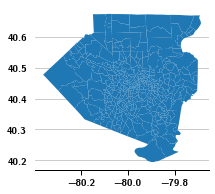

In [18]:
allegheny_tracts = pa_tracts[pa_tracts.COUNTYFP == "003"]
allegheny_tracts.plot()

In [19]:
individuals_race_poverty_tracts = pa_tracts.join(individuals_race_poverty, how="inner")

/home/matt/.virtualenvs/traffic-equilibrium/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


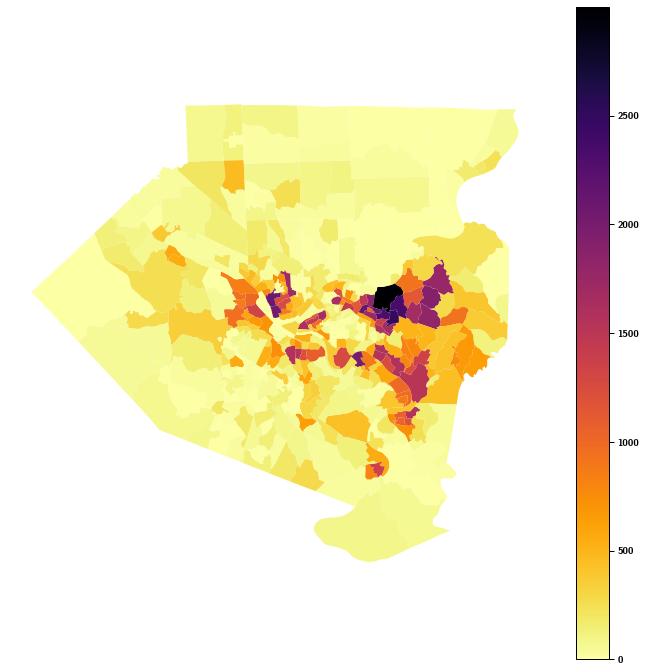

In [20]:
fig, ax = plt.subplots(figsize=(12, 12))
individuals_race_poverty_tracts.plot((DataKind.total, Race.black), ax=ax, legend=True, cmap="inferno_r")
ax.axis("off")
None

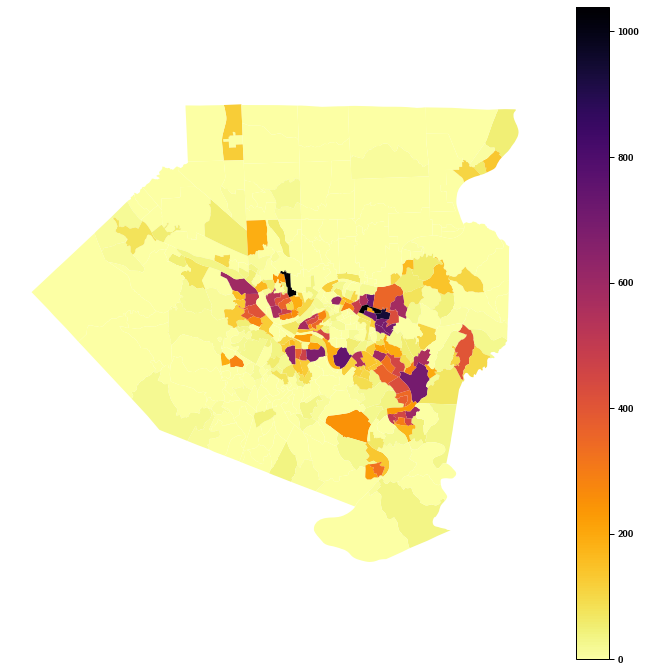

In [21]:
fig, ax = plt.subplots(figsize=(12, 12))
individuals_race_poverty_tracts.plot((DataKind.poverty, Race.black), ax=ax, legend=True, cmap="inferno_r")
ax.axis("off")
None

In [22]:
def unpickle(fname: str):
    with open(fname, 'rb') as fp:
        return pickle.load(fp)
    
INT_SIZE = 64
BYTE_ORDER = "little"

def to_path_uuid(link_ids):
    m = hashlib.md5()
    for link_id in sorted(link_ids):
        m.update(link_id.to_bytes(INT_SIZE, BYTE_ORDER))
    return str(uuid.UUID(m.hexdigest()))
    
class FleetData:
    def __init__(self, data, prefix):
        self.data = data
        self.prefix = prefix
        
    def key(self, k):
        return '_'.join([self.prefix, k])
    
    @property
    def path_flow(self):
        return self.data[self.key('flow')]
    
    @property
    def number_of_paths(self):
        return len(self.path_flow)
    
    @property
    def link_flow(self):
        return self.link_path_incidence @ self.path_flow
    
    @property
    def usable_path_mask(self):
        return self.data[self.key('paths')]

    @property
    def usable_paths(self):
        return pd.Series(
            self.usable_path_mask,
            name=f"is_{self.prefix}_usable_path"
        )
    
    @property
    def trip_path_incidence(self):
        return self.data['trip_path']
    
    @property
    def link_path_incidence(self):
        return self.data['link_path']
    
    @property
    def trip_flow(self):
        return self.trip_path_incidence @ self.path_flow
    
    @property
    def link_path_index(self):
        lpm_coo = self.link_path_incidence.tocoo()
        return pd.DataFrame({
            'link_id': lpm_coo.row,
            'path_id': lpm_coo.col,
        }).set_index('path_id').sort_index()
    
    @property
    def trip_path_index(self):
        tpm_coo = self.trip_path_incidence.tocoo()
        return pd.DataFrame({
            'trip_id': tpm_coo.row,
            'path_id': tpm_coo.col,
        }).set_index('path_id').sort_index()
    
    @property
    def path_uuids(self):
        return self.link_path_index.groupby("path_id").link_id.apply(to_path_uuid).rename("path_uuid")
    
    def trip_path_flow(self, trip_id):
        return (
            self.trip_path_incidence[trip_id]
                .multiply(self.path_flow)
        ) 
    
    def trip_link_flow(self, trip_id):
        return (
            self.link_path_incidence
            @ self.trip_path_flow(trip_id).T
        ).toarray().squeeze()
    
    def to_path_dataframe(self):
        return (
            pd.DataFrame({
                self.prefix: self.path_flow,
                'path_id': np.arange(self.number_of_paths),
            }).set_index('path_id')
              .join(self.trip_path_index)
              .join(self.usable_paths)
              .join(self.path_uuids)
              .set_index(['path_uuid', 'trip_id'])
        )
    
    def to_link_dataframe(self):
        return pd.DataFrame({
            self.prefix: self.link_flow,
            "link_id": np.arange(len(self.link_flow))
        }).set_index('link_id')


class CriticalFleetSizeResult:
    def __init__(self, data, node_geom = None):
        self.data = data
        self.node_geom = node_geom
        self.fleet = FleetData(self.data, "fleet")
        self.user = FleetData(self.data, "user")
        self.solver_result = FWResult.load(os.path.join(PROJECT_ROOT, data['result']))
        
    @property
    def fleet_trip_fraction(self):
        return self.fleet.trip_flow / (self.fleet.trip_flow + self.user.trip_flow)
        
    @property
    def fleet_path_fraction(self):
        return self.fleet.path_flow / (self.fleet.path_flow + self.user.path_flow)
    
    @property
    def fleet_link_fraction(self):
        return self.fleet.link_flow / (self.fleet.link_flow + self.user.link_flow)
    
    @property
    def link_path_incidence(self):
        return self.data['link_path']
    
    @property
    def trip_path_incidence(self):
        return self.data['trip_path']
    
    @property
    def fleet_fraction(self):
        return self.fleet.path_flow.sum() / (self.fleet.path_flow + self.user.path_flow).sum()
    
    @property
    def link_path_index(self):
        lpm_coo = self.link_path_incidence.tocoo()
        return pd.DataFrame({
            'link_id': lpm_coo.row,
            'path_id': lpm_coo.col,
        }).set_index("path_id")
    
    @property
    def trip_path_index(self):
        tpm_coo = self.trip_path_incidence.tocoo()
        return pd.DataFrame({
            'trip_id': tpm_coo.row,
            'path_id': tpm_coo.col,
        }).set_index('path_id').sort_index()
    
    def to_link_cost_dataframe(self):
        return pd.DataFrame({
            "link_cost": self.data["link_cost"],
            "link_marginal_cost": self.data["link_marginal_cost"],
            "link_fleet_marginal_cost": self.data["link_cost"] + np.multiply(self.fleet.link_flow, self.data["link_cost_gradient"]),
            "link_cost_gradient": self.data.get("link_cost_gradient", np.NaN),
            "link_id": np.arange(len(self.data["link_cost"])),
        }).set_index("link_id")
    
    def to_path_cost_dataframe(self):
        _lc = self.to_link_cost_dataframe()
        return (
            self.to_trip_path_link_index()
                .reset_index()
                .set_index("link_id")
                .join(_lc)
                .groupby(["trip_id", "path_uuid"])
                .sum()
                .reset_index("trip_id")
        )
    
    @property
    def path_uuids(self):
        return self.link_path_index.groupby("path_id").link_id.apply(to_path_uuid).rename("path_uuid")
    
    def to_trip_info_dataframe(self):
        trips = pd.DataFrame(
            self.solver_result.problem.demand.to_trip_tuples(),
            columns=['trip_id', 'source_id', 'target_id', 'volume']
        ).set_index('trip_id')
        return trips
        
    
    def to_trip_path_link_index(self):
        return (
            self.trip_path_index
                .join(self.link_path_index)
                .join(self.path_uuids)
                .set_index(["trip_id", "path_uuid"])
        )
    
    def to_path_geodataframe(self):
        link_geom = self.to_link_geodataframe()[['geometry']]
        path_geom = (
            self.link_path_index
                .join(self.path_uuids)
                .set_index('link_id')
                .join(link_geom)
                .set_index('path_uuid')
        )
        return gpd.GeoDataFrame(path_geom).dissolve(by='path_uuid')
    
    def to_path_dataframe(self):
        return (self.to_path_geodataframe()
                    .join(self.fleet.to_path_dataframe())
                    .join(self.user.to_path_dataframe())
                    .join(self.to_path_cost_dataframe())
               )
    
    def to_link_dataframe(self):
        return (self.to_link_geodataframe()
                    .join(self.fleet.to_link_dataframe())
                    .join(self.user.to_link_dataframe())
                    .join(self.to_link_cost_dataframe())
               )
    
    def to_link_geodataframe(self):
        net = self.solver_result.problem.network
        ldf = (pd.DataFrame
                 .from_dict(net.link_info,
                            orient='index')
              )
        ldf.index = ldf.index.map(int).rename('link_id')
        if "geometry" in ldf.columns:
            ldf['geometry'] = ldf.geometry.apply(shape)
            ldf = gpd.GeoDataFrame(ldf).set_geometry("geometry").set_crs(epsg=6565)
        else:
            ldf["geometry"] = ldf.reset_index().merge(
                self.node_geom[["Node", "geometry"]].rename(columns={"geometry": "from_pt"}),
                left_on="from_node",
                right_on="Node",
            ).merge(
                self.node_geom[["Node", "geometry"]].rename(columns={"geometry": "to_pt"}),
                left_on="to_node",
                right_on="Node",
            ).set_index("link_id").apply(lambda row: LineString([row.from_pt, row.to_pt]), axis=1)
            ldf = gpd.GeoDataFrame(ldf).set_geometry("geometry").set_crs(self.node_geom.crs)
        link_nodes = pd.DataFrame(net.links(), columns=['from_node_id', 'to_node_id'])
        link_nodes.index.name = 'link_id'
        return ldf.join(link_nodes)
    
    
    @property
    def link_flow(self):
        return self.fleet.link_flow + self.user.link_flow
    

class Result:
    kinds = ('mcr', 'lp', 'mip')
    
    def __init__(self, prefix, node_geom=None):
        for kind in self.kinds:
            try:
                data = CriticalFleetSizeResult(unpickle(f"{prefix}.{kind}.pkl"), node_geom)
            except FileNotFoundError:
                data = None
            setattr(self, kind, data)
            
    def _to_path_dataframe(self):
        value_vars = ['fleet', 'user']
        dfs = []
        new_index = 'solution_concept'
        for kind in self.kinds:
            result = getattr(self, kind)
            if result is not None:
                df = result.to_path_dataframe()
                df['aggregate_flow'] = df[value_vars].sum(axis=1)
                df[new_index] = kind
                df.set_index(new_index, append=True, inplace=True)
                dfs.append(df)
        df = pd.concat(dfs)
        id_vars = list(set(df.columns) - set(value_vars))
        df = (df.melt(ignore_index=False,
                      id_vars=id_vars, value_vars=value_vars,
                      var_name='flow_class', value_name='flow')
                .set_index('flow_class', append=True)
                .sort_index()
             )
        return df
        
    def to_path_dataframe(self):
        return self._to_path_dataframe().join(self.path_impact())
    
    def to_link_dataframe(self):
        value_vars = ['fleet', 'user']
        dfs = []
        new_index = 'solution_concept'
        for kind in self.kinds:
            result = getattr(self, kind)
            if result is not None:
                df = result.to_link_dataframe()
                df['aggregate_flow'] = df[value_vars].sum(axis=1)
                df[new_index] = kind
                df.set_index(new_index, append=True, inplace=True)
                dfs.append(df)
        df = pd.concat(dfs)
        id_vars = list(set(df.columns) - set(value_vars))
        df = (df.melt(ignore_index=False,
                      id_vars=id_vars,
                      value_vars=value_vars,
                      var_name='flow_class', value_name='flow')
                .set_index('flow_class', append=True)
                .sort_index()
             )
        return df
    
    @property
    def link_path_index(self):
        dfs = []
        for kind in self.kinds:
            result = getattr(self, kind)
            if result is not None:
                dfs.append(result.to_trip_path_link_index())
        return pd.concat(dfs).reset_index().drop_duplicates().set_index(["trip_id", "path_uuid"])

    def path_impact(self):
        is_fleet_usable = self._to_path_dataframe().groupby("path_uuid").is_fleet_usable_path.first()
        n_fleet_usable = is_fleet_usable.sum()
        link_path = self.link_path_index.join(is_fleet_usable).reset_index().set_index(["link_id"])
        link_grad = (self.mcr or self.lp).to_link_cost_dataframe().link_cost_gradient
        def _compute_impact(link_ids):
	        return sum(link_grad.loc[lid] * (n_fleet_usable - link_path.loc[lid].is_fleet_usable_path.sum()) for lid in link_ids)
        path_links = link_path.reset_index().groupby("path_uuid").link_id.apply(set)
        return path_links.apply(_compute_impact).rename("path_impact")


def plot_with_basemap(gdf, *args, buffer=0, shift=0, size=20, extent=None, source=ctx.providers.CartoDB.Positron, copy=True, **kwargs):
    #if extent is not None:
    #    gdf = gdf[gdf.intersects(extent)].copy()
    if copy:
        gdf = gdf.copy()
    if extent is not None:
        xmin, ymin, xmax, ymax = extent.bounds
    else:
        xmin, ymin, xmax, ymax = gdf.unary_union.buffer(buffer).bounds
    aspect = (xmax-xmin) / (ymax-ymin)
    fig, ax = plt.subplots(figsize=(size, aspect*size))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    if args:
        cax.set_title(args[0])
    shift_geometry(gdf, shift).plot(*args, ax=ax, cax=cax, **kwargs)
    ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax])
    ctx.add_basemap(ax, crs=gdf.crs, source=source)
    ax.axis('off')
    return ax


def with_flow_stats(link_flow_df):
    link_flow_df["V/C"] = link_flow_df.flow / link_flow_df.capacity
    link_flow_df["Aggregate V/C"] = link_flow_df.aggregate_flow / link_flow_df.capacity
    link_flow_df["link_flow_fraction"] = link_flow_df.flow / link_flow_df.aggregate_flow
    return link_flow_df

def with_path_stats(path_flow_df):
    path_flow_df['is_used'] = (path_flow_df.flow > 0)
    path_flow_df['flow_fraction'] = path_flow_df.flow / path_flow_df.aggregate_flow
    path_flow_df['is_exclusive'] = path_flow_df.flow_fraction >= 0.95
    return path_flow_df

def shift_geometry(link_flow_df, shift):
    if shift:
        link_flow_df['geometry'] = link_flow_df.geometry.apply(LineShifter(shift))
    return link_flow_df


class LineShifter:
    def __init__(self, alpha):
        self.alpha = alpha
        
    def __call__(self, line):
        fn = {
            'LineString': self._line_shift,
            'MultiLineString': self._multi_line_shift
        }.get(line.type)
        if fn is None:
            raise Exception(f"Cannot shift geometry of type {line.type}")
        else:
            return fn(line)
        
    def _multi_line_shift(self, multi_line):
        return MultiLineString([
            self._line_shift(line)
            for line in multi_line
        ])
    
    def _line_shift(self, line):
        coords = iter(line.coords)
        x0, y0 = next(coords)
        shifted_coords = [(x0, y0)]
        for x1, y1 in coords:
            shifted_coords.pop()
            shifted_coords.extend(shift_line_segment_coords(
                x0, y0, x1, y1, self.alpha
            ))
            x0, y0 = x1, y1
        return LineString(shifted_coords)

def safe_div(a, b):
    if b == 0:
        return 0.0
    else:
        return a / b

def shift_line_segment_coords(x0, y0, x1, y1, alpha):
    dx = (x1 - x0)
    dy = (y1 - y0)
    z = (dx**2 + dy**2)**0.5
    return [
        (x0 - alpha * safe_div(dy, z), y0 + alpha * safe_div(dx, z)),
        (x1 - alpha * safe_div(dy, z), y1 + alpha * safe_div(dx, z))
    ]

def zoom_to(ax, center_pt=None, level=1):
    xmin, xmax = ax.get_xlim()
    dx = (xmax - xmin) / level
    ymin, ymax = ax.get_ylim()
    dy = (ymax - ymin) / level
    if center_pt is None:
        x, y = (xmax-xmin)/2.0, (ymax-ymin)/2.0
    else:
        x, y = center_pt
        assert xmin <= x <= xmax
        assert ymin <= y <= ymax
    ax.set_xlim([x - dx, x + dx])
    ax.set_ylim([y - dy, y + dy])
    return ax

def add_demand_level_index(df, demand_level):
    df["demand_level"] = demand_level
    return df.set_index("demand_level", append=True)

def place_to_extent(place, crs, buffer_dist=0):
    return ox.geocode_to_gdf(place, buffer_dist=buffer_dist).to_crs(crs).unary_union

def select(df, **kwargs):
    keys, values = zip(*kwargs.items())
    return df.xs(
        values,
        level=keys,
        drop_level=False
    )

def flatten_columns(df):
    df.columns = ['_'.join(filter(None, col)) for col in df.columns.values]
    return df

def map_style():
    return matplotlib.style.context("./maps.mplstyle")

def set_linestyles(g, linestyles):
    axes = list(g.axes_dict.values())or [g.ax]
    for ax in axes:
        legend = ax.legend_ or g.legend
        handles = [None]*len(linestyles) if legend is None else legend.legendHandles
        for lines, linestyle, legend_handle in zip(ax.lines[::-1], linestyles, handles):
            lines.set_linestyle(linestyle)
            if legend_handle is not None:
                legend_handle.set_linestyle(linestyle)

In [23]:
def concentration_category(flow_fraction):
    if flow_fraction <= 0.05:
        return "empty"
    if flow_fraction >= 0.95:
        return "full"
    elif 0.5 < flow_fraction < 0.95:
        return "mixed"
    else:
        return "unused"


def with_usability_and_concentration(path_df):
    path_df["is_user_and_fleet_usable"] = path_df.is_user_usable_path & path_df.is_fleet_usable_path
    path_df["concentration"] = path_df.flow_fraction.apply(concentration_category)

In [24]:
link_dfs = []
path_dfs = []
trip_info_dfs = []
trip_path_link_dfs = []
min_demand = 50.0
for demand_level in [1.0]:
    res = Result(f"../spc-greater-pgh-{demand_level}-cfs-eps-1e-8-beta-1.0-final")
    link_dfs.append(add_demand_level_index(res.to_link_dataframe(), demand_level))
    path_dfs.append(add_demand_level_index(res.to_path_dataframe(), demand_level))
    trip_info_dfs.append(add_demand_level_index(res.mcr.to_trip_info_dataframe(), demand_level))
    trip_path_link_dfs.append(res.link_path_index)
spc_link_flow = with_flow_stats(pd.concat(link_dfs))
spc_path_flow = with_path_stats(pd.concat(path_dfs))
spc_trip_info = pd.concat(trip_info_dfs)
spc_trip_path_link_idx = pd.concat(trip_path_link_dfs)
with_usability_and_concentration(spc_path_flow)

In [25]:
spc_link_flow["is_virtual"] = spc_link_flow.capacity >= 9999.0
spc_link_flow["length_mi"] = spc_link_flow.length / FEET_PER_MILE
spc_link_flow["capacity_miles"] = spc_link_flow.capacity * spc_link_flow.length_mi
spc_link_flow["lane_miles"] = spc_link_flow.lanes * spc_link_flow.length_mi

In [26]:
pgh_ue = FWResult.load("results/pittsburgh-network-mpo-greater-pgh-1.0-min-50.0-NoThruTrips_fw-ue/results-2021-10-20T21:09:25")
pgh_ue_trip_cost = pd.Series(pgh_ue.trip_cost.to_array(), name="trip_cost").rename_axis("trip_id")

In [27]:
# Get node geom from spc_link_flow
spc_nodes = pd.concat([
    spc_link_flow[["from_node_id", "from_point"]].rename(columns={"from_node_id": "node_id", "from_point": "point"}),
    spc_link_flow[["to_node_id", "to_point"]].rename(columns={"to_node_id": "node_id", "to_point": "point"})
]).set_index("node_id").groupby("node_id").first()
geom = gpd.points_from_xy(
    spc_nodes.point.apply(lambda pt: pt.get("longitude", np.nan)),
    spc_nodes.point.apply(lambda pt: pt.get("latitude", np.nan)),
    crs="EPSG:4326"
)
spc_nodes = gpd.GeoDataFrame(spc_nodes, geometry=geom)
spc_nodes.head()

,point,geometry
node_id,,
0,"{'longitude': -80.0054258, 'latitude': 40.4405...",POINT (-80.00543 40.44055)
1,"{'longitude': -80.0058297, 'latitude': 40.4399...",POINT (-80.00583 40.43992)
2,"{'longitude': -80.0045401, 'latitude': 40.4402...",POINT (-80.00454 40.44029)
3,"{'longitude': -80.003018, 'latitude': 40.4391999}",POINT (-80.00302 40.43920)
4,"{'longitude': -80.002979, 'latitude': 40.4388271}",POINT (-80.00298 40.43883)


In [28]:
spc_trips = spc_trip_info.reset_index().merge(
    spc_nodes["geometry"].rename("source_geom").reset_index(),
    left_on="source_id", right_on="node_id", how="left"
).drop(columns=["node_id"]).merge(
    spc_nodes["geometry"].rename("target_geom").reset_index(),
    left_on="target_id", right_on="node_id", how="left"
).drop(columns=["node_id"]).set_index("trip_id")
spc_trips = gpd.GeoDataFrame(spc_trips).set_geometry("source_geom")

In [29]:
# associate trip stats to orgn/dest tract
spc_trip_flows = spc_trips.join(spc_path_flow.drop(columns="trip_id").groupby(["solution_concept", "flow_class", "trip_id"])[["flow", "aggregate_flow"]].sum())
spc_trip_flows.head()

demand_level  source_id  target_id  \
solution_concept flow_class trip_id                                       
lp               fleet      0                 1.0          0          7   
                            1                 1.0          0         11   
                            2                 1.0          0         26   
                            3                 1.0          3          7   
                            4                 1.0          3         11   

                                     volume                 source_geom  \
solution_concept flow_class trip_id                                       
lp               fleet      0          55.0  POINT (-80.00543 40.44055)   
                            1          97.0  POINT (-80.00543 40.44055)   
                            2          68.0  POINT (-80.00543 40.44055)   
                            3         112.0  POINT (-80.00302 40.43920)   
                            4         163.0  POINT (-80.00302 40.43920)   

                                                    target_geom   flow  \
solution_concept flow_class trip_id                                      
lp               fleet      0        POINT (-80.00158 40.44090)   55.0   
                            1        POINT (-80.00588 40.44265)   97.0   
                            2        POINT (-79.99694 40.44192)   68.0   
                            3        POINT (-80.00158 40.44090)    0.0   
                            4        POINT (-80.00588 40.44265)  163.0   

                                     aggregate_flow  
solution_concept flow_class trip_id                  
lp               fleet      0                  55.0  
                            1                  97.0  
                            2                  68.0  
                            3                 112.0  
                            4                 163.0

In [30]:
spc_link_tracts = gpd.sjoin(
    allegheny_tracts[["geometry"]].to_crs(spc_link_flow.crs),
    spc_link_flow[~spc_link_flow.is_virtual].reset_index()
).drop(
    columns="index_right"
).set_index(
    spc_link_flow.index.names,
    append=True
).groupby(
    ["geoid", "solution_concept", "flow_class"]
)[["flow", "aggregate_flow", "link_cost", "length_mi", "capacity_miles", "lane_miles"]].sum()
spc_link_tracts

flow  \
geoid                solution_concept flow_class                 
1400000US42003010301 lp               fleet       49785.174343   
                                      user         2351.179583   
                     mcr              fleet       28912.444285   
                                      user        25367.048609   
1400000US42003010302 lp               fleet       43736.565100   
...                                                        ...   
1400000US42003981800 mcr              user         9976.745495   
1400000US42003982200 lp               fleet       75440.398117   
                                      user         5109.113293   
                     mcr              fleet       37313.134155   
                                      user        42377.033641   

                                                  aggregate_flow  \
geoid                solution_concept flow_class                   
1400000US42003010301 lp               fleet         52136.353926   
                                      user          52136.353926   
                     mcr              fleet         54279.492895   
                                      user          54279.492895   
1400000US42003010302 lp               fleet         45711.448453   
...                                                          ...   
1400000US42003981800 mcr              user          14661.564857   
1400000US42003982200 lp               fleet         80549.511410   
                                      user          80549.511410   
                     mcr              fleet         79690.167796   
                                      user          79690.167796   

                                                     link_cost  length_mi  \
geoid                solution_concept flow_class                            
1400000US42003010301 lp               fleet       1.118406e+05  12.592476   
                                      user        1.118406e+05  12.592476   
                     mcr              fleet       1.118406e+05  12.592476   
                                      user        1.118406e+05  12.592476   
1400000US42003010302 lp               fleet       1.129142e+05   6.956346   
...                                                        ...        ...   
1400000US42003981800 mcr              user        1.530370e+04   6.047284   
1400000US42003982200 lp               fleet       2.763635e+06   4.557287   
                                      user        2.763635e+06   4.557287   
                     mcr              fleet       2.763635e+06   4.557287   
                                      user        2.763635e+06   4.557287   

                                                  capacity_miles  lane_miles  
geoid                solution_concept flow_class                              
1400000US42003010301 lp               fleet         12772.570244   23.318566  
                                      user          12772.570244   23.318566  
                     mcr              fleet         12772.570244   23.318566  
                                      user          12772.570244   23.318566  
1400000US42003010302 lp               fleet          5774.988412   12.932066  
...                                                          ...         ...  
1400000US42003981800 mcr              user           4759.240686    7.955696  
1400000US42003982200 lp               fleet          3257.435552    9.735345  
                                      user           3257.435552    9.735345  
                     mcr              fleet          3257.435552    9.735345  
                                      user           3257.435552    9.735345  

[1120 rows x 6 columns]

In [31]:
link_tracts = spc_link_tracts.join(ind_race_poverty_l)
link_tracts["volume_per_lane_mile"] = link_tracts.flow / link_tracts.lane_miles
link_tracts.head()

flow  \
geoid                solution_concept flow_class poverty race                                                             
1400000US42003010301 lp               fleet      True    White alone                                       49785.174343   
                                                         Black or African American alone                   49785.174343   
                                                         American Indian and Alaska Native alone           49785.174343   
                                                         Asian alone                                       49785.174343   
                                                         Native Hawaiian and Other Pacific Islander alone  49785.174343   

                                                                                                           aggregate_flow  \
geoid                solution_concept flow_class poverty race                                                               
1400000US42003010301 lp               fleet      True    White alone                                         52136.353926   
                                                         Black or African American alone                     52136.353926   
                                                         American Indian and Alaska Native alone             52136.353926   
                                                         Asian alone                                         52136.353926   
                                                         Native Hawaiian and Other Pacific Islander alone    52136.353926   

                                                                                                               link_cost  \
geoid                solution_concept flow_class poverty race                                                              
1400000US42003010301 lp               fleet      True    White alone                                       111840.590575   
                                                         Black or African American alone                   111840.590575   
                                                         American Indian and Alaska Native alone           111840.590575   
                                                         Asian alone                                       111840.590575   
                                                         Native Hawaiian and Other Pacific Islander alone  111840.590575   

                                                                                                           length_mi  \
geoid                solution_concept flow_class poverty race                                                          
1400000US42003010301 lp               fleet      True    White alone                                       12.592476   
                                                         Black or African American alone                   12.592476   
                                                         American Indian and Alaska Native alone           12.592476   
                                                         Asian alone                                       12.592476   
                                                         Native Hawaiian and Other Pacific Islander alone  12.592476   

                                                                                                           capacity_miles  \
geoid                solution_concept flow_class poverty race                                                               
1400000US42003010301 lp               fleet      True    White alone                                         12772.570244   
                                                         Black or African American alone                     12772.570244   
                                                         American Indian and Alaska Native alone             12772.570244   
                                          

In [32]:
race = ind_race_poverty_l.groupby("race").population.sum().sort_values(ascending=False)
races = race[(race / race.sum()) >= 0.01].index

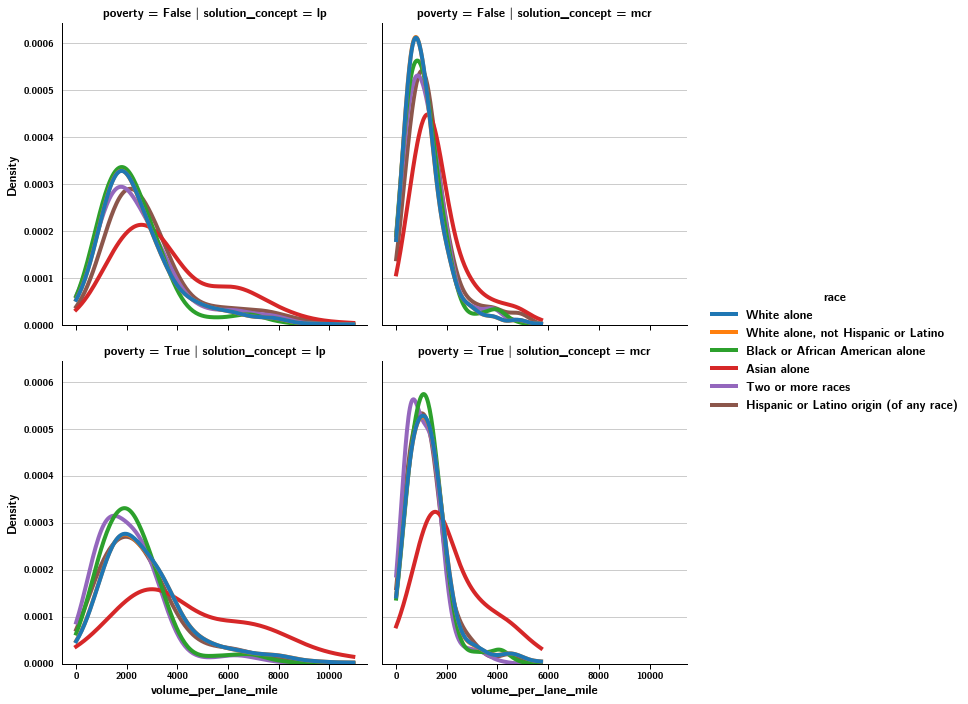

In [33]:
link_tracts["pop_weights"] = link_tracts.groupby(["solution_concept", "flow_class", "race", "poverty"]
                       ).population.transform(lambda pop: pop / pop.sum())
g = sns.displot(
    data=link_tracts.xs("fleet", level="flow_class").reset_index(),
    #kind="hist", stat="density", element="step", fill=None, common_norm=False,
    kind="kde", cut=0, common_norm=False,
    weights="population",
    x="volume_per_lane_mile",
    hue="race",
    hue_order=races,
    row="poverty",
    col="solution_concept"
)

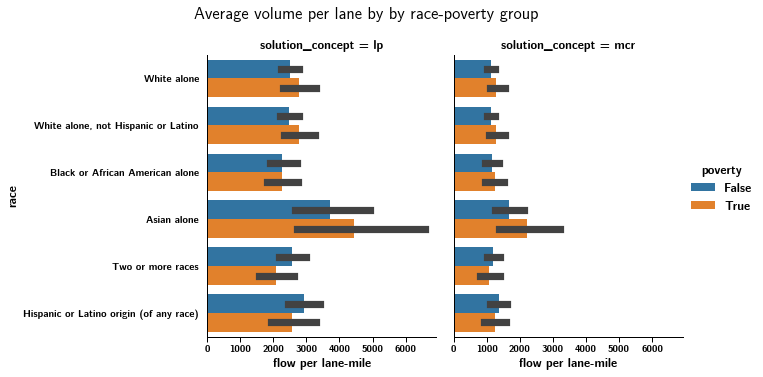

In [34]:
link_tracts["pop_weighted_volume_per_lane_mile"] = (
#     link_tracts.groupby(["solution_concept", "flow_class", "race", "poverty"]
#                        ).population.transform(lambda pop: pop / pop.sum())
    link_tracts.pop_weights *
    link_tracts.volume_per_lane_mile
)
g = sns.catplot(
    data=link_tracts.xs("fleet", level="flow_class").reset_index(),
    y="race",
    order=races,
    hue="poverty",
    x="pop_weighted_volume_per_lane_mile",
    col="solution_concept",
    estimator=np.sum,
    orient="h",
    kind="bar"
)
g.set_xlabels("flow per lane-mile")
g.fig.suptitle("Average volume per lane by by race-poverty group", y=1.05)
g.savefig("./volume-per-lane-mile.png", dpi=600, bbox_inches="tight")

In [35]:
from scipy.stats import ttest_ind_from_stats
import itertools as it

race_poverty = list(it.product([Race.white, Race.black, Race.asian, Race.hispanic], [True, False], ["lp"]))

data = []
for rpa, rpb in it.product(race_poverty, race_poverty):
    if (rpa[-1] == rpb[-1]) and (rpa != rpb):
        a = link_tracts.xs(rpa, level=("race", "poverty", "solution_concept"))
        b = link_tracts.xs(rpb, level=("race", "poverty", "solution_concept"))
        res = ttest_ind_from_stats(
            a.pop_weighted_volume_per_lane_mile.mean(), a.pop_weighted_volume_per_lane_mile.std(), len(a),
            b.pop_weighted_volume_per_lane_mile.mean(), b.pop_weighted_volume_per_lane_mile.std(), len(b),
            equal_var=False
        )
        data.append(rpa + rpb + (res.pvalue,))
pvals = pd.DataFrame(data, columns=["race_a", "poverty_a", "sol_a", "race_b", "poverty_b", "sol_b", "pvalue"]).set_index(["race_a", "poverty_a", "sol_a", "race_b", "poverty_b", "sol_b"]).sort_values("pvalue")
print(len(data) / 2)
pvals*(len(data)/2)

28.0


,,,,,,pvalue
race_a,poverty_a,sol_a,race_b,poverty_b,sol_b,
Asian alone,False,lp,Black or African American alone,True,lp,0.489975
Black or African American alone,True,lp,Asian alone,False,lp,0.489975
Asian alone,False,lp,Black or African American alone,False,lp,0.549492
Black or African American alone,False,lp,Asian alone,False,lp,0.549492
Asian alone,True,lp,Black or African American alone,True,lp,0.605984
Black or African American alone,True,lp,Asian alone,True,lp,0.605984
Asian alone,True,lp,Black or African American alone,False,lp,0.674682
Black or African American alone,False,lp,Asian alone,True,lp,0.674682
Asian alone,True,lp,White alone,False,lp,1.200724


In [36]:
orgn_tract_flow = gpd.sjoin(
    allegheny_tracts,
    spc_trip_flows.reset_index().to_crs(pa_tracts.crs),
).set_index(["solution_concept", "flow_class"], append=True).groupby(["solution_concept", "flow_class", "geoid"])[["flow", "aggregate_flow"]].sum()
orgn_tract_flow["flow_fraction"] = orgn_tract_flow.flow / orgn_tract_flow.aggregate_flow
orgn_tract_flow = allegheny_tracts[["geometry"]].join(orgn_tract_flow).set_geometry("geometry").fillna(0.0)

In [37]:
dest_tract_flow = gpd.sjoin(
    allegheny_tracts,
    spc_trip_flows.set_geometry("target_geom").reset_index().to_crs(pa_tracts.crs),
).set_index(["solution_concept", "flow_class"], append=True).groupby(["solution_concept", "flow_class", "geoid"])[["flow", "aggregate_flow"]].sum()
dest_tract_flow["flow_fraction"] = dest_tract_flow.flow / dest_tract_flow.aggregate_flow
dest_tract_flow = allegheny_tracts[["geometry"]].join(dest_tract_flow).set_geometry("geometry").fillna(0.0)

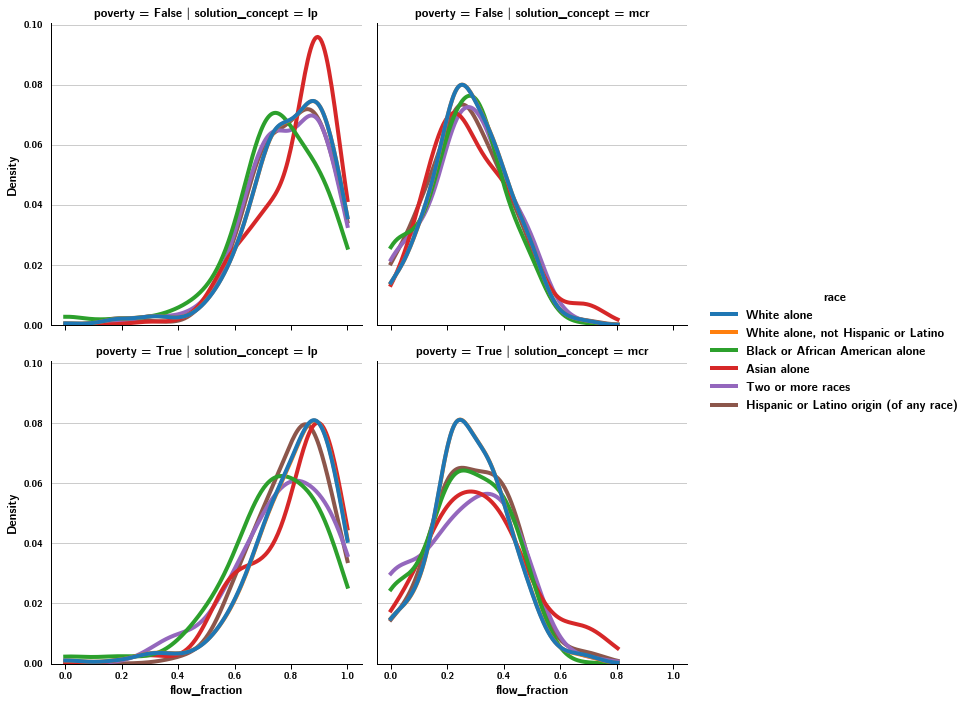

In [38]:
_df = orgn_tract_flow.join(ind_race_poverty_l)
g = sns.displot(
    data=_df.xs("fleet", level="flow_class").reset_index(),
    kind="kde", cut=0, weights="population",
    x="flow_fraction",
    hue="race",
    hue_order=races,
    row="poverty",
    col="solution_concept"
)

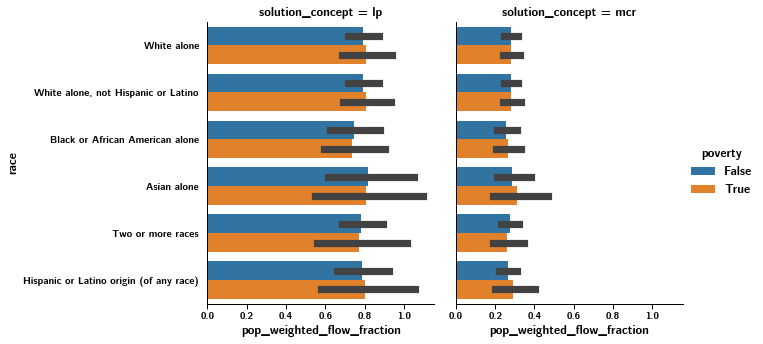

In [39]:
_df["pop_weighted_flow_fraction"] = (
    _df.groupby(["solution_concept", "flow_class", "race", "poverty"]
                       ).population.transform(lambda pop: pop / pop.sum())
    * _df.flow_fraction
)
g = sns.catplot(
    data=_df.xs("fleet", level="flow_class").reset_index(),
    y="race",
    order=races,
    hue="poverty",
    x="pop_weighted_flow_fraction",
    col="solution_concept",
    estimator=np.sum,
    orient="h",
    kind="bar"
)

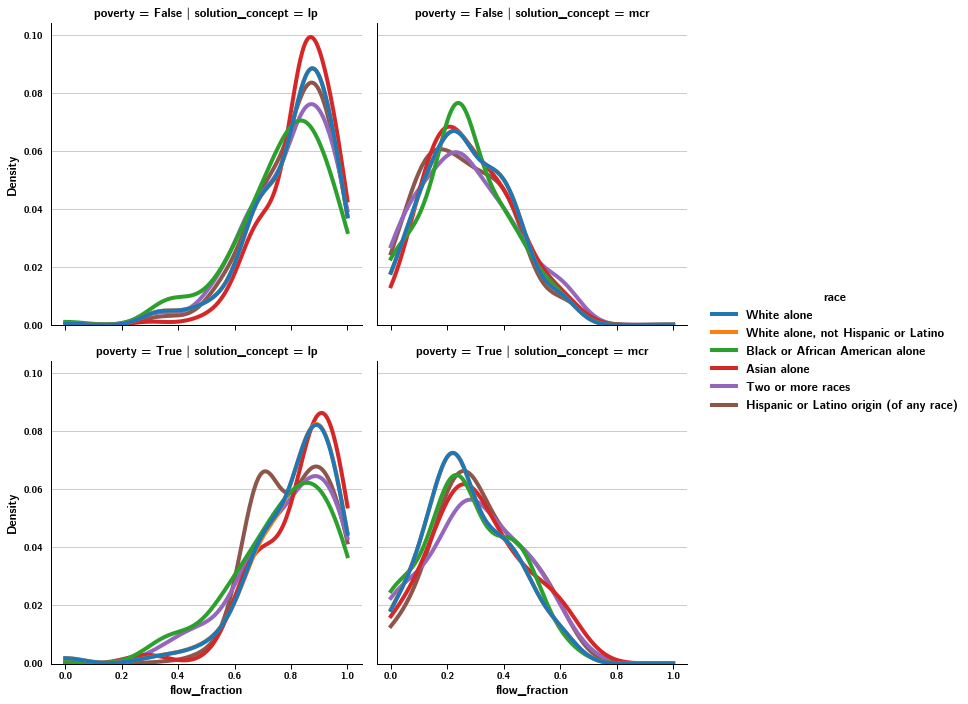

In [40]:
_df = dest_tract_flow.join(ind_race_poverty_l)
g = sns.displot(
    data=_df.xs("fleet", level="flow_class").reset_index(),
    kind="kde", cut=0, weights="population",
    x="flow_fraction",
    hue="race",
    hue_order=races,
    row="poverty",
    col="solution_concept"
)

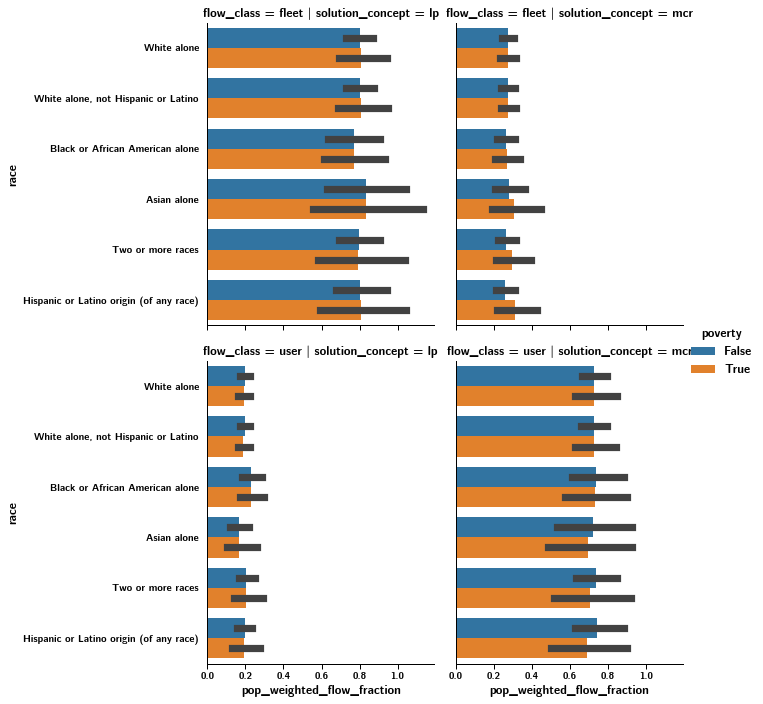

In [41]:
_df["pop_weighted_flow_fraction"] = (
    _df.groupby(["solution_concept", "flow_class", "race", "poverty"]
                       ).population.transform(lambda pop: pop / pop.sum())
    * _df.flow_fraction
)
g = sns.catplot(
    data=_df.reset_index(),
    y="race",
    order=races,
    row="flow_class",
    hue="poverty",
    x="pop_weighted_flow_fraction",
    col="solution_concept",
    estimator=np.sum,
    orient="h",
    kind="bar"
)

In [42]:
from scipy.stats import ttest_ind_from_stats
import itertools as it

race_poverty = list(it.product([Race.white, Race.black, Race.asian, Race.hispanic], [True, False], ["lp", "mcr"]))

data = []
for rpa, rpb in it.product(race_poverty, race_poverty):
    if (rpa[-1] == rpb[-1]) and (rpa != rpb):
        a = _df.xs(rpa, level=("race", "poverty", "solution_concept"))
        b = _df.xs(rpb, level=("race", "poverty", "solution_concept"))
        res = ttest_ind_from_stats(
            a.pop_weighted_flow_fraction.mean(), a.pop_weighted_flow_fraction.std(), len(a),
            b.pop_weighted_flow_fraction.mean(), b.pop_weighted_flow_fraction.std(), len(b),
            equal_var=False
        )
        data.append(rpa + rpb + (res.pvalue,))
pvals = pd.DataFrame(data, columns=["race_a", "poverty_a", "sol_a", "race_b", "poverty_b", "sol_b", "pvalue"]).set_index(["race_a", "poverty_a", "sol_a", "race_b", "poverty_b", "sol_b"]).sort_values("pvalue")
pvals < 0.05 / (len(data)/2)

pvalue
race_a                                  poverty_a sol_a race_b                                  poverty_b sol_b        
White alone                             True      lp    White alone                             False     lp      False
Asian alone                             False     mcr   Asian alone                             True      mcr     False
                                                        Black or African American alone         False     mcr     False
                                                                                                True      mcr     False
                                                        White alone                             False     mcr     False
...                                                                                                                 ...
Black or African American alone         True      lp    Asian alone                             True      lp      False
                                                        Black or African American alone         False     lp      False
                                                        White alone                             False     lp      False
Hispanic or Latino origin (of any race) False     mcr   Asian alone                             False     mcr     False
                                                        Hispanic or Latino origin (of any race) True      mcr     False

[112 rows x 1 columns]

In [43]:
spc_path_flow["total_cost"] = spc_path_flow.flow * spc_path_flow.link_cost
spc_path_flow["avg_cost"] = spc_path_flow.flow * spc_path_flow.link_cost / spc_path_flow.drop(columns=["trip_id"]).groupby(["solution_concept", "flow_class", "trip_id"]).flow.transform("sum")
spc_trip_cost = spc_path_flow.drop(columns=["trip_id"]).groupby(["solution_concept", "flow_class", "trip_id"]).agg(
    avg_cost=("avg_cost", "sum"),
    flow=("flow", "sum")
)
spc_trip_cost = spc_trip_cost.join(pgh_ue_trip_cost.rename("ue_trip_cost"))
spc_trip_cost["gap"] = spc_trip_cost.avg_cost / spc_trip_cost.ue_trip_cost - 1
spc_trip_cost

avg_cost   flow  ue_trip_cost  \
solution_concept flow_class trip_id                                      
lp               fleet      0        22660.784704   55.0  23702.611014   
                            1         7534.222448   97.0   8313.082118   
                            2        15635.313844   68.0  15622.381959   
                            3            0.000000    0.0  19530.175112   
                            4        11491.046524  163.0  11337.993353   
...                                           ...    ...           ...   
mcr              user       4876         0.000000    0.0  22555.149027   
                            4877     35096.791601   84.0  37276.322898   
                            4878     30462.875038   75.0  30148.865440   
                            4879         0.000000    0.0  23885.799185   
                            4880      6934.506834   70.0   6776.731612   

                                          gap  
solution_concept flow_class trip_id            
lp               fleet      0       -0.043954  
                            1       -0.093691  
                            2        0.000828  
                            3       -1.000000  
                            4        0.013499  
...                                       ...  
mcr              user       4876    -1.000000  
                            4877    -0.058470  
                            4878     0.010415  
                            4879    -1.000000  
                            4880     0.023282  

[19524 rows x 4 columns]

In [44]:
_df = spc_trip_flows.join(spc_trip_cost[["avg_cost", "gap"]]).rename(columns={"avg_cost": "cost"})
orgn_tract_cost = gpd.sjoin(
    allegheny_tracts,
    _df.reset_index().to_crs(allegheny_tracts.crs),
).set_index(_df.index.names, append=True)
orgn_tract_cost["avg_cost"] = orgn_tract_cost.flow * orgn_tract_cost.cost / orgn_tract_cost.groupby(["solution_concept", "flow_class", "geoid"]).flow.transform("sum")
orgn_tract_cost["avg_gap"] = orgn_tract_cost.flow * orgn_tract_cost.gap / orgn_tract_cost.groupby(["solution_concept", "flow_class", "geoid"]).flow.transform("sum")
orgn_tract_cost = orgn_tract_cost.groupby(["solution_concept", "flow_class", "geoid"]).agg(
    avg_cost=("avg_cost", "sum"),
    avg_gap=("avg_gap", "sum")
).join(ind_race_poverty_l)

In [45]:
orgn_tract_cost

avg_cost  \
geoid                solution_concept flow_class poverty race                                                              
1400000US42003010302 lp               fleet      True    White alone                                       119218.615173   
                                                         Black or African American alone                   119218.615173   
                                                         American Indian and Alaska Native alone           119218.615173   
                                                         Asian alone                                       119218.615173   
                                                         Native Hawaiian and Other Pacific Islander alone  119218.615173   
...                                                                                                                  ...   
1400000US42003982200 mcr              user       False   Native Hawaiian and Other Pacific Islander alone  546878.958215   
                                                         Some other race alone                             546878.958215   
                                                         Two or more races                                 546878.958215   
                                                         Hispanic or Latino origin (of any race)           546878.958215   
                                                         White alone, not Hispanic or Latino               546878.958215   

                                                                                                            avg_gap  \
geoid                solution_concept flow_class poverty race                                                         
1400000US42003010302 lp               fleet      True    White alone                                       0.034942   
                                                         Black or African American alone                   0.034942   
                                                         American Indian and Alaska Native alone           0.034942   
                                                         Asian alone                                       0.034942   
                                                         Native Hawaiian and Other Pacific Islander alone  0.034942   
...                                                                                                             ...   
1400000US42003982200 mcr              user       False   Native Hawaiian and Other Pacific Islander alone -0.006680   
                                                         Some other race alone                            -0.006680   
                                                         Two or more races                                -0.006680   
                                                         Hispanic or Latino origin (of any race)          -0.006680   
                                                         White alone, not Hispanic or Latino              -0.006680   

                                                                                                           population  
geoid                solution_concept flow_class poverty race                                                          
1400000US42003010302 lp               fleet      True    White alone                                            174.0  
                                                         Black or African American alone                        151.0  
                                                         American Indian and Alaska Native alone                  0.0  
                                                         Asian alone                                             30.0  
                                                         Native Hawaiian and Other Pacific Islander alone         0.0  
...                                                                                                            

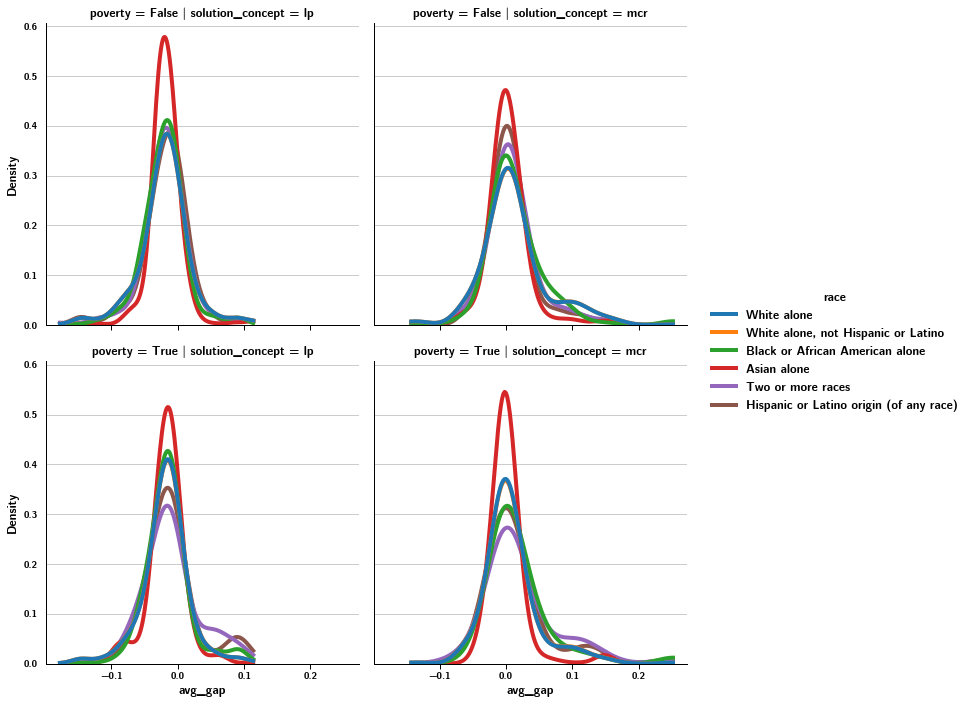

In [46]:
g = sns.displot(
    data=orgn_tract_cost.xs("fleet", level="flow_class").reset_index(),
    kind="kde", cut=0, weights="population",
    x="avg_gap",
    hue="race",
    hue_order=races,
    row="poverty",
    col="solution_concept"
)

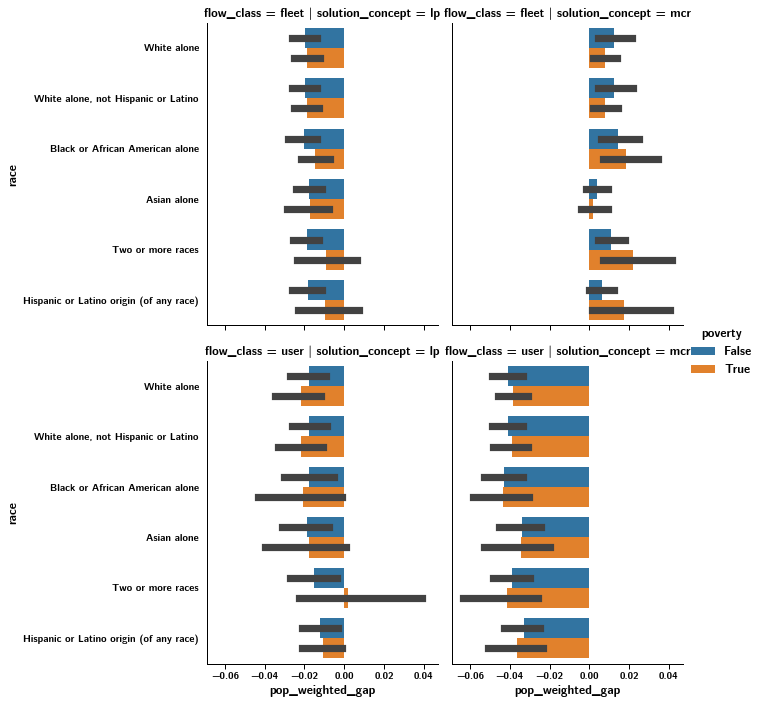

In [47]:
orgn_tract_cost["pop_weighted_gap"] = (
    orgn_tract_cost.groupby(["solution_concept", "flow_class", "race", "poverty"]
                       ).population.transform(lambda pop: pop / pop.sum())
    * orgn_tract_cost.avg_gap
)
g = sns.catplot(
    data=orgn_tract_cost.reset_index(),
    y="race",
    order=races,
    hue="poverty",
    x="pop_weighted_gap",
    col="solution_concept",
    row="flow_class",
    estimator=np.sum,
    orient="h",
    kind="bar"
)

In [48]:
from scipy.stats import ttest_ind_from_stats
import itertools as it

race_poverty = list(it.product([Race.white, Race.black, Race.asian, Race.hispanic], [True, False], ["lp", "mcr"]))

data = []
for rpa, rpb in it.product(race_poverty, race_poverty):
    if (rpa[-1] == rpb[-1]) and (rpa != rpb):
        a = orgn_tract_cost.xs(rpa, level=("race", "poverty", "solution_concept"))
        b = orgn_tract_cost.xs(rpb, level=("race", "poverty", "solution_concept"))
        res = ttest_ind_from_stats(
            a.pop_weighted_gap.mean(), a.pop_weighted_gap.std(), len(a),
            b.pop_weighted_gap.mean(), b.pop_weighted_gap.std(), len(b),
            equal_var=False
        )
        data.append(rpa + rpb + (res.pvalue,))
pvals = pd.DataFrame(data, columns=["race_a", "poverty_a", "sol_a", "race_b", "poverty_b", "sol_b", "pvalue"]).set_index(["race_a", "poverty_a", "sol_a", "race_b", "poverty_b", "sol_b"]).sort_values("pvalue")
pvals < 0.01 / (len(data)/2)

pvalue
race_a                                  poverty_a sol_a race_b                                  poverty_b sol_b        
Hispanic or Latino origin (of any race) True      lp    White alone                             True      lp      False
White alone                             True      lp    Hispanic or Latino origin (of any race) True      lp      False
Hispanic or Latino origin (of any race) True      lp    White alone                             False     lp      False
White alone                             False     lp    Hispanic or Latino origin (of any race) True      lp      False
Hispanic or Latino origin (of any race) True      lp    Black or African American alone         False     lp      False
...                                                                                                                 ...
White alone                             True      mcr   Asian alone                             False     mcr     False
                                        False     lp    Black or African American alone         False     lp      False
Black or African American alone         False     lp    White alone                             False     lp      False
Asian alone                             True      lp    Black or African American alone         True      lp      False
Black or African American alone         True      lp    Asian alone                             True      lp      False

[112 rows x 1 columns]

In [49]:
so_path_flow = spc_path_flow.xs(
    ("lp", "fleet"),
    level=("solution_concept", "flow_class")
)[["aggregate_flow", "link_cost", "geometry"]
 ].rename(columns={"aggregate_flow": "flow", "link_cost": "cost"})
so_path_flow["avg_cost"] = (
    so_path_flow.flow * so_path_flow.cost
    / so_path_flow.groupby("trip_id").flow.transform("sum")
)
so_trip_cost = so_path_flow.groupby("trip_id").agg(
    avg_cost=("avg_cost", "sum")
)
so_trip_cost = so_trip_cost.join(pgh_ue_trip_cost.rename("ue_cost"))
so_trip_cost["gap"] = so_trip_cost.avg_cost / so_trip_cost.ue_cost - 1

In [50]:
ue_so_tracts = gpd.sjoin(
    allegheny_tracts,
    spc_trips.set_geometry("source_geom").join(so_trip_cost).reset_index().to_crs(allegheny_tracts.crs)
).set_index(so_trip_cost.index.names, append=True).join(ind_race_poverty_l)

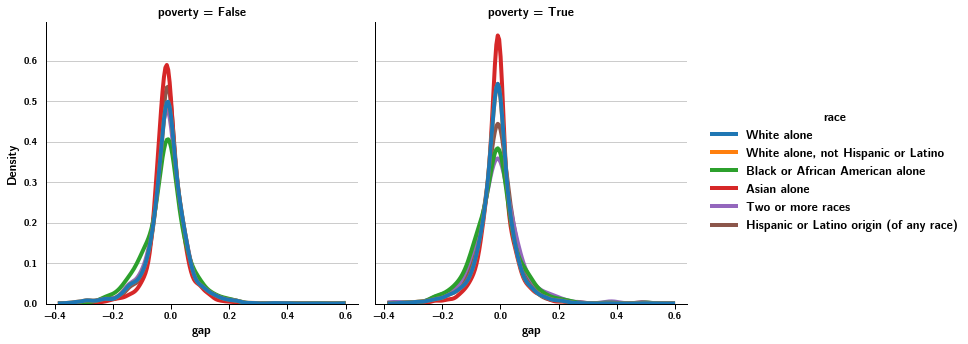

In [51]:
g = sns.displot(
    data=ue_so_tracts.reset_index(),
    kind="kde", cut=0, weights="population",
    x="gap",
    hue="race",
    hue_order=races,
    col="poverty",
)

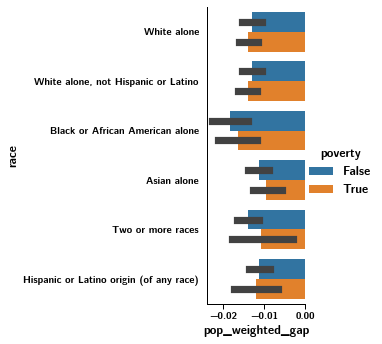

In [52]:
ue_so_tracts["pop_weighted_gap"] = (
    ue_so_tracts.groupby(["race", "poverty"]
                       ).population.transform(lambda pop: pop / pop.sum())
    * ue_so_tracts.gap
)
g = sns.catplot(
    data=ue_so_tracts.reset_index(),
    y="race",
    order=races,
    hue="poverty",
    x="pop_weighted_gap",
    #col="solution_concept",
    #row="poverty",
    estimator=np.sum,
    orient="h",
    kind="bar"
)

In [53]:
from scipy.stats import ttest_ind_from_stats
import itertools as it

race_poverty = list(it.product([Race.white, Race.black, Race.asian, Race.hispanic], [True, False]))
data = []
for rpa, rpb in it.product(race_poverty, race_poverty):
    if rpa != rpb:
        a = ue_so_tracts.xs(rpa, level=("race", "poverty"))
        b = ue_so_tracts.xs(rpb, level=("race", "poverty"))
        res = ttest_ind_from_stats(
            a.pop_weighted_gap.mean(), a.pop_weighted_gap.std(), len(a),
            b.pop_weighted_gap.mean(), b.pop_weighted_gap.std(), len(b),
            equal_var=False
        )
        data.append(rpa + rpb + (res.pvalue,))
pvals = pd.DataFrame(data, columns=["race_a", "poverty_a", "race_b", "poverty_b", "pvalue"]).set_index(["race_a", "poverty_a", "race_b", "poverty_b"]).sort_values("pvalue")
pvals < 0.05 / (len(data)/2)

pvalue
race_a                                  poverty_a race_b                                  poverty_b        
Asian alone                             True      Black or African American alone         False        True
Black or African American alone         False     Asian alone                             True         True
Asian alone                             False     Black or African American alone         False       False
Black or African American alone         False     Asian alone                             False       False
                                                  Hispanic or Latino origin (of any race) False       False
Hispanic or Latino origin (of any race) False     Black or African American alone         False       False
Asian alone                             True      Black or African American alone         True        False
Black or African American alone         True      Asian alone                             True        False
White alone                             False     Black or African American alone         False       False
Black or African American alone         False     White alone                             False       False
White alone                             True      Asian alone                             True        False
Asian alone                             True      White alone                             True        False
                                        False     Black or African American alone         True        False
Black or African American alone         True      Asian alone                             False       False
Hispanic or Latino origin (of any race) False     Black or African American alone         True        False
Black or African American alone         True      Hispanic or Latino origin (of any race) False       False
                                        False     Hispanic or Latino origin (of any race) True        False
Hispanic or Latino origin (of any race) True      Black or African American alone         False       False
White alone                             True      Black or African American alone         False       False
Black or African American alone         False     White alone                             True        False
Asian alone                             True      White alone                             False       False
White alone                             False     Asian alone                             True        False
Asian alone                             False     White alone                             True        False
White alone                             True      Asian alone                             False       False
                                                  Hispanic or Latino origin (of any race) False       False
Hispanic or Latino origin (of any race) False     White alone                             True        False
Black or African American alone         True      White alone                             False       False
White alone                             False     Black or African American alone         True        False
Black or African American alone         True      Hispanic or Latino origin (of any race) True        False
Hispanic or Latino origin (of any race) True      Black or African American alone         True        False
Asian alone                             False     White alone                             False       False
White alone                             False     Asian alone                             False       False
                                                  Hispanic or Latino origin (of any race) False       False
Hispanic or Latino origin (of any race) False     White alone                             False       False
Black or African American alone         True      White alone                             True        False
White alone                             True      Black or African American alone         True        Fal

In [54]:
list(race_poverty)

[('White alone', True),
 ('White alone', False),
 ('Black or African American alone', True),
 ('Black or African American alone', False),
 ('Asian alone', True),
 ('Asian alone', False),
 ('Hispanic or Latino origin (of any race)', True),
 ('Hispanic or Latino origin (of any race)', False)]

# Misc.

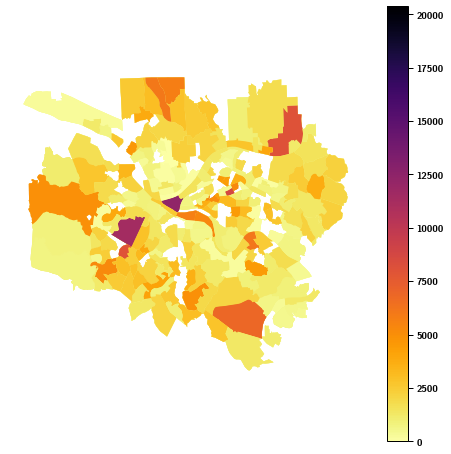

In [55]:
fig, ax = plt.subplots(figsize=(8, 8))
orgn_tract_flow.plot("flow", ax=ax, cmap="inferno_r", legend=True)
ax.axis("off")
None

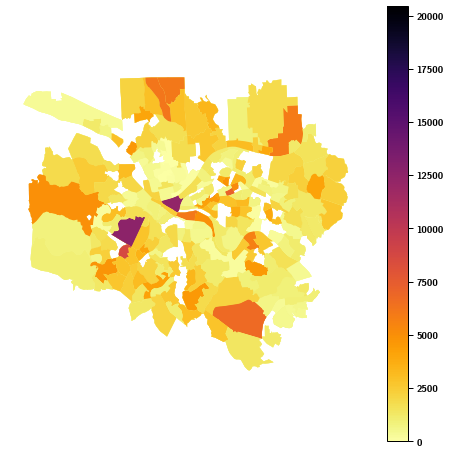

In [56]:
fig, ax = plt.subplots(figsize=(8, 8))
dest_tract_flow.plot("flow", ax=ax, cmap="inferno_r", legend=True)
ax.axis("off")
None

In [153]:
_df = gpd.GeoDataFrame(ind_race_poverty_l.join(orgn_tract_flow)).set_geometry("geometry").dropna().xs(("lp", "fleet"), level=("solution_concept", "flow_class"))

In [179]:
_orgn_tract_flow = orgn_tract_flow.xs(("lp", "fleet"), level=("solution_concept", "flow_class"))
least_access_tracts = _orgn_tract_flow.sort_values("flow").head(int(len(_orgn_tract_flow) * 0.05)).index

In [180]:
_df.loc[least_access_tracts].population.sum() / _df.population.sum()

0.023771423739438063

In [181]:
_orgn_tract_flow.loc[least_access_tracts].flow.sum() / _orgn_tract_flow.flow.sum()

0.0008525164507784492

In [182]:
_df["has_fleet"] = True
_df.loc[least_access_tracts, "has_fleet"] = False

In [183]:
_df.groupby(["has_fleet"]).population.sum() / _df.population.sum()

has_fleet
False    0.023771
True     0.976229
Name: population, dtype: float64

In [184]:
_df.groupby(["poverty", "has_fleet"]).population.sum() / _df.groupby(["poverty"]).population.sum()

poverty  has_fleet
False    False        0.021979
         True         0.978021
True     False        0.036536
         True         0.963464
Name: population, dtype: float64

In [185]:
_df.groupby(["has_fleet", "poverty"]).population.sum() / _df.groupby(["has_fleet"]).population.sum()

has_fleet  poverty
False      False      0.810733
           True       0.189267
True       False      0.878469
           True       0.121531
Name: population, dtype: float64

In [186]:
_df.groupby("poverty").population.sum() / _df.population.sum()

poverty
False    0.876859
True     0.123141
Name: population, dtype: float64

In [189]:
link_tracts["has_access"] = True
link_tracts.loc[least_access_tracts, "has_access"] = False

In [199]:
_ldf = link_tracts.xs(("lp", "fleet"), level=("solution_concept", "flow_class"))
_ldf.groupby("has_access").volume_per_lane_mile.mean()

has_access
False    1207.435519
True     2650.849273
Name: volume_per_lane_mile, dtype: float64

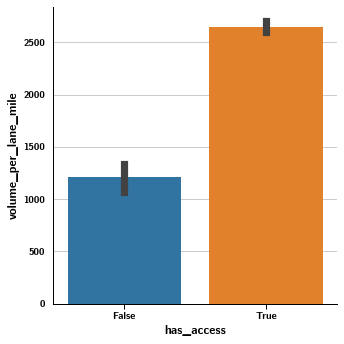

In [201]:
sns.catplot(
    data=_ldf.reset_index(),
    x="has_access",
    y="volume_per_lane_mile",
    kind="bar"
)

In [227]:
poverty_rates = (_df.groupby(["geoid", "poverty"]).population.sum() / _df.groupby(["geoid"]).population.sum()).dropna().sort_values(ascending=False).xs(True, level="poverty").rename("poverty_rates")
poverty_tracts = poverty_rates.head(int(0.10 * 215)).index
_df["highest_poverty"] = False
_df.loc[poverty_tracts, "highest_poverty"] = True

In [234]:
nonwhite_rates = 1.0 - (
    _df.groupby(["geoid", "race"]).population.sum()
    / _df.groupby(["geoid"]).population.sum()
).dropna().xs(Race.white, level="race").rename("nonwhite_rates").sort_values(ascending=False)
nonwhite_tracts = nonwhite_rates.head(int(0.10 * 215)).index
_df["highest_minority"] = False
_df.loc[nonwhite_tracts, "highest_minority"] = True

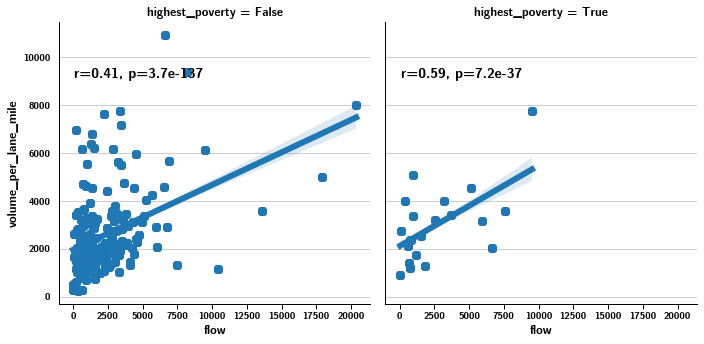

In [232]:
import scipy
g = sns.lmplot(
    data=_df.join(_ldf.volume_per_lane_mile).join(poverty_rates).reset_index().dropna(),
    x="flow",
    y="volume_per_lane_mile",
    col="highest_poverty"
)
def annotate(data, **kws):
    r, p = scipy.stats.pearsonr(data['flow'], data['volume_per_lane_mile'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)

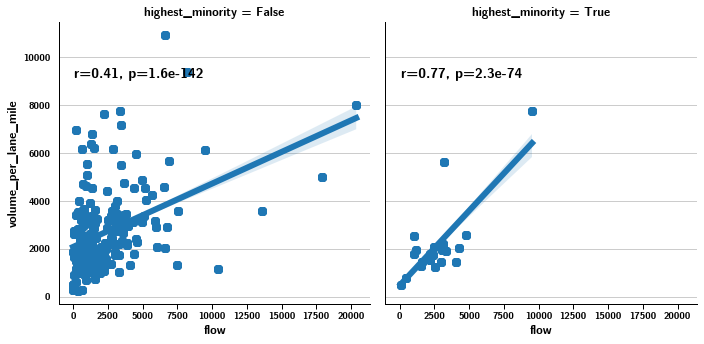

In [238]:
import scipy
g = sns.lmplot(
    data=_df.join(_ldf.volume_per_lane_mile).reset_index().dropna(),
    x="flow",
    y="volume_per_lane_mile",
    col="highest_minority"
)
def annotate(data, **kws):
    r, p = scipy.stats.pearsonr(data['flow'], data['volume_per_lane_mile'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)

In [ ]:
_df["race_weighted_flow_fraction"] = _df.flow_fraction * _df.poverty_percent

In [ ]:
sns.catplot(
    data=_df.reset_index(),
    y="race",
    x="race_weighted_flow_fraction",
    kind="bar", orient="h",
    hue="solution_concept",
    col="flow_class"
)

In [ ]:
sns.relplot(
    data=_df.reset_index(),
    x=(DataKind.poverty_percent, Race.white),
    y="flow",
    col="solution_concept",
    hue="flow_class"
)

In [ ]:
ind_race_poverty_tracts_links = gpd.sjoin(individuals_race_poverty_tracts.to_crs(spc_link_flow.crs), spc_link_flow.reset_index()).drop(columns="index_right").set_index(spc_link_flow.index.names, append=True)

In [ ]:
ind_race_poverty_tracts_links

In [ ]:
_df = ind_race_poverty_tracts_links[~ind_race_poverty_tracts_links.is_virtual].groupby(["solution_concept", "flow_class", "geoid"])[["flow", "link_cost", "aggregate_flow", "length_mi", "capacity_miles"]].sum().join(individuals_race_poverty_tracts.to_crs(spc_link_flow.crs))
_df["volume_per_capacity_mile"] = _df.flow / _df.capacity_miles
_df["volume_per_mile"] = _df.flow / _df.length_mi
_df["cost_per_capacity_mile"] = _df.link_cost / _df.capacity_miles
_df["cost_per_mile"] = _df.link_cost / _df.length_mi

In [ ]:
_df.groupby(["solution_concept", "flow_class" ])

In [ ]:
sns.relplot(
    data=_df,
    x=(DataKind.poverty_percent, Race.black),
    y="volume_per_mile",
    col="solution_concept",
    hue="flow_class"
)

In [ ]:
sns.relplot(
    data=_df,
    x=(DataKind.poverty_percent, Race.white),
    y="volume_per_mile",
    col="solution_concept",
    hue="flow_class"
)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
_df.loc["mcr", "fleet"].plot("volume_per_mile", ax=ax, legend=True, cmap="inferno_r")
ax.axis("off")
None

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
_df.loc["lp", "fleet"].plot("volume_per_mile", ax=ax, legend=True, cmap="inferno_r")
ax.axis("off")
None

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
_df.loc["lp", "fleet"].plot("volume_per_capacity_mile", ax=ax, legend=True, cmap="inferno_r")
ax.axis("off")
None

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
_df.loc["lp", "fleet"].plot("cost_per_mile", ax=ax, legend=True, cmap="inferno_r")
ax.axis("off")
None

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
_df.loc["lp", "fleet"].plot("cost_per_capacity_mile", ax=ax, legend=True, cmap="inferno_r")
ax.axis("off")
None